In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import scipy.linalg
from pathlib import Path
from collections import defaultdict
import yaml
from matplotlib import pyplot as plt

from regdpp.general import ROOT_DIR, DATA_DIR
from regdpp.sample import SamplerRegistry
from regdpp.utils import load_libsvm_data
from regdpp.metrics import A_opt_criterion
from regdpp.plot import plot_results

In [2]:
dataset = "mg_scale"

config_path = Path(ROOT_DIR, 'configs', f'{dataset}.yaml')
config = yaml.safe_load(config_path.open('r'))

In [3]:
print(yaml.safe_dump(config))

dataset: mg_scale
dump_path: dump
figpath: figs
methods:
  greedy:
    name: Greedy
    params: {}
    target: Greedy
  plain_reg_dpp:
    name: Reg DPP w/o SDP
    params:
      sdp: false
    target: RegDPP
  predictive_length:
    name: Predictive length
    params: {}
    target: PredictiveLength
  reg_dpp_sdp:
    name: Reg DPP w SDP
    params:
      sdp: true
    target: RegDPP
  uniform:
    name: Uniform
    params: {}
    target: Uniform
shared:
  criterion: A
  max_size_scale: 5
  min_size_scale: 1.5
  n_repeat: 25
  n_sizes: 10
ylim:
- 0
- 20



In [4]:
X = load_libsvm_data(Path(DATA_DIR, config["dataset"]))
n, d = X.shape

shared = config["shared"]

k_range = np.linspace(
    shared["min_size_scale"] * d, shared["max_size_scale"] * d, shared["n_sizes"], dtype=int
)
n_repeat = shared["n_repeat"]
criteria = defaultdict(lambda: np.empty((len(k_range), n_repeat)))
times = dict()

A = 1.0 / n * np.eye(d)

for method, params in config["methods"].items():
    print(params["name"])
    target = params["target"]
    sampler = SamplerRegistry.create_sampler(target, **params["params"])
    for k_id, k in (list(enumerate(k_range))):
        print(f"Looking for subset of size {k}")

        for rep_id in range(n_repeat):
            S = sampler(X, A, k)

            X_S = X[S]
            subset_cov = X_S.T @ X_S
            A_optimal_criterium = A_opt_criterion(subset_cov, A)
            criteria[params["name"]][k_id, rep_id] = A_optimal_criterium
    
    sampler.time_cnts = np.array(sampler.time_cnts).reshape((len(k_range), n_repeat))
    if sampler.__class__.__name__ == "Greedy":
        sampler.time_cnts = np.cumsum(sampler.time_cnts[:, [0]], axis=0)
    times[params["name"]] = sampler.time_cnts
    print(
        f"Time of sampling: {np.mean(sampler.time_cnts):.3f} +- {1.96 * np.std(sampler.time_cnts):.3f}"
    )


Greedy
Looking for subset of size 9
Looking for subset of size 11
Looking for subset of size 13
Looking for subset of size 16
Looking for subset of size 18
Looking for subset of size 20
Looking for subset of size 23
Looking for subset of size 25
Looking for subset of size 27
Looking for subset of size 30
Time of sampling: 1.495 +- 1.075
Uniform
Looking for subset of size 9
Looking for subset of size 11
Looking for subset of size 13
Looking for subset of size 16
Looking for subset of size 18
Looking for subset of size 20
Looking for subset of size 23
Looking for subset of size 25
Looking for subset of size 27
Looking for subset of size 30
Time of sampling: 0.000 +- 0.000
Predictive length
Looking for subset of size 9
Looking for subset of size 11
Looking for subset of size 13
Looking for subset of size 16
Looking for subset of size 18
Looking for subset of size 20
Looking for subset of size 23
Looking for subset of size 25
Looking for subset of size 27
Looking for subset of size 30
Time

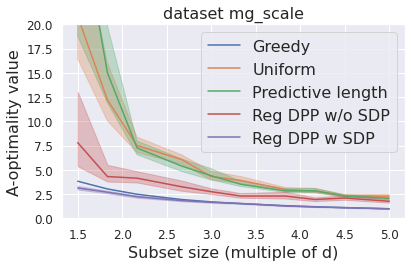

In [5]:
plot_results(
    criteria,
    k_range,
    d,
    ylabel="A-optimality value",
    ylim=config["ylim"] if config["ylim"] else None,
    dataset=config["dataset"],
    show=True
    )

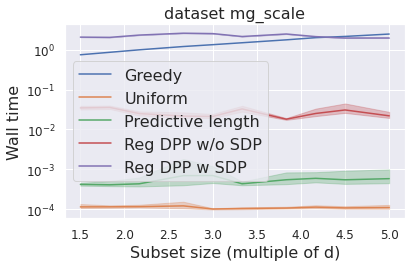

In [6]:
plot_results(
    times,
    k_range,
    d,
    ylabel="Wall time",
    dataset=config["dataset"],
    yscale="log",
    show=True
)

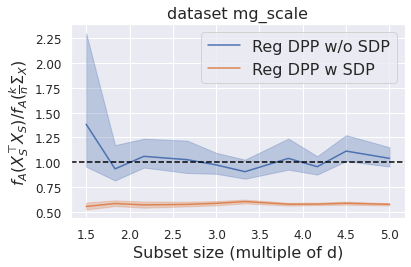

In [7]:
cov = X.T @ X
baseline = np.array([A_opt_criterion(k / n * cov, A) for k in k_range])
criteria_ = {
    config["methods"][key]["name"]: criteria[config["methods"][key]["name"]] / baseline[:, None]
    for key in ["plain_reg_dpp", "reg_dpp_sdp"]
}
fig = plot_results(criteria_, k_range, d, dataset=config["dataset"])
plt.ylabel(r"$f_A(X_S^{\top}X_S)/f_A(\frac{k}{n}\Sigma_X)$")
plt.axhline(y=1.0, color="black", linestyle="--")
fig.tight_layout()
plt.show()